In [1]:
import sys; sys.path.insert(0, "..")
from src.models import NLM, NeuralNet
from src.utils import generate_data

from scipy.special import logsumexp
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
from autograd.scipy.stats import multivariate_normal
import numpy
import numpy.matlib
import math
import pdb
import matplotlib.pyplot as plt

In [2]:
# def generate_data_periodic(number_of_points=10, noise_variance=9):
#     """Function for generating toy regression data"""
#     #training x
#     x_train = np.hstack((np.linspace(-4, -1, number_of_points), np.linspace(1, 4, number_of_points)))
#     #function relating x and y
#     f = lambda x: x**3 + 20 * np.sin(7 * x)
#     #y is equal to f(x) plus gaussian noise
#     y_train = f(x_train) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
#     # x_test = np.array(list(set(list(np.hstack((np.linspace(-5, , 100), x_train))))))
#     x_test = np.array(list(set(list((np.linspace(-6, 6, 100))))))
#     x_test = np.sort(x_test)
#     return x_train, y_train, x_test

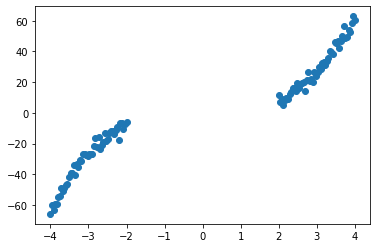

In [3]:
x, y, x_test = generate_data(number_of_points=50, noise_variance=9)

plt.scatter(x, y)

plt.show()

In [4]:
class LUNA:
    def __init__(self, architecture, random=None, weights=None):
        # Sanity check
        assert len(architecture['width']) == architecture['hidden_layers']

        self.params = {'H': architecture['width'], # list of number of nodes per layer
                       'L': architecture['hidden_layers'], # number of hidden layers
                       'M': architecture['auxiliary_functions'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        # Input layer
        input_weights = architecture['input_dim'] * architecture['width'][0] + architecture['width'][0]

        # Loop over each layer
        hidden_weights = 0
        for i, h in enumerate(architecture['width'][1:]):
          # Multiply previous layer width by current layer width plus the bias (current layer width)
          hidden_weights += architecture['width'][i] * h + h

        # Output layer
        output_weights = (architecture['output_dim'] * architecture['width'][-1] + architecture['output_dim'])

        self.D = input_weights + hidden_weights + output_weights ## this is the size of the parameters that will be used for inference

        self.D_theta = input_weights + hidden_weights
        self.D_aux = self.params['M']*output_weights
        self.D_w = output_weights
        self.D_full = self.D_theta + self.D_aux

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
            self.weights_full = self.random.normal(0, 1, size=(1, self.D_full))
            self.theta = self.weights_full[0][:self.D_theta]
        else:
            self.weights = weights
            self.weights_full = weights ## error?

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D_full))

    def forward(self, weights, x, return_feature_map = False):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        # print(weights.shape[1])
        # print(self.D)
        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        # input to first hidden layer
        W = weights[:H[0] * D_in].T.reshape((-1, H[0], D_in))
        b = weights[H[0] * D_in:H[0] * D_in + H[0]].T.reshape((-1, H[0], 1))
        input = self.h(np.matmul(W, x) + b)
        index = H[0] * D_in + H[0]

        assert input.shape[1] == H[0]

        # additional hidden layers
        for i in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H[i] * H[i+1]].T.reshape((-1, H[i+1], H[i]))
            index += H[i] * H[i+1]
            b = weights[index:index + H[i+1]].T.reshape((-1, H[i+1], 1))
            index += H[i+1]
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H[i+1]

        if return_feature_map:
            return input[0,:,:].T # Transform into shape (n x p)

        # output layer
        W = weights[index:index + H[-1] * D_out].T.reshape((-1, D_out, H[-1]))
        b = weights[index + H[-1] * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def forward_with_auxiliary(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']
        M = self.params['M']

        assert weights.shape[1] == self.D_full

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T

        # input to first hidden layer
        W = weights[:H[0] * D_in].T.reshape((-1, H[0], D_in))
        b = weights[H[0] * D_in:H[0] * D_in + H[0]].T.reshape((-1, H[0], 1))
        input = self.h(np.matmul(W, x) + b)
        index = H[0] * D_in + H[0]

        assert input.shape[1] == H[0]

        # additional hidden layers
        for i in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H[i] * H[i+1]].T.reshape((-1, H[i+1], H[i]))
            index += H[i] * H[i+1]
            b = weights[index:index + H[i+1]].T.reshape((-1, H[i+1], 1))
            index += H[i+1]
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H[i+1]

        # output layer (unique for LUNA)
        W = weights[index:index + H[-1] * D_out * M].T.reshape((M, D_out, H[-1]))
        index += H[-1] * D_out * M
        b = weights[index:].T.reshape((M, D_out, 1))
        index += D_out * M
        assert index == self.D_full
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def finite_diff_grad(self, W_full, x_train):
        std_del = 0.1
#             delta_x = self.random.normal(0, std_del, size=(x_train.shape[1]) )  # use different perturbations for each x's
        delta_x = self.random.normal(0, std_del) # use one perturbation value for all x's        
        x_for = x_train + delta_x
        x_return = self.forward_with_auxiliary(W_full, x_for) -  self.forward_with_auxiliary(W_full, x_train)
        return np.divide(x_return, delta_x) # M x D_out x num of samples

    
    def make_objective_LUNA(self, x_train, y_train, lambda_in, reg_param=None):
        M = self.params['M']

        def objective(W_full, t):
            # Compute L_fit
            y_train_rep = np.tile(y_train, (M,1,1)) # repeat y_train with shape = D_out x n_sample to M x D_out x n_sample
            squared_error = np.linalg.norm(y_train_rep - self.forward_with_auxiliary(W_full, x_train), axis=1)**2
            if reg_param is None:
                L_fit = np.sum(squared_error) / M
            else:
                L_fit = np.mean(squared_error) + reg_param * np.linalg.norm(W_full)
            
            # Comput L_diverse (#### Now only works for D_in = 1 and D_out = 1 ####)
            grad_FD = np.squeeze(self.finite_diff_grad(W_full, x_train)) # reshape to M x num of samples
            grad_angle = np.arctan(grad_FD) # compute the "angle of those gradients"
            grad_angle_rep = np.tile(grad_angle,(M,1,1)) # repeate the matrix to create M x M x num of samples
            grad_angle_rep_transpose = np.transpose(grad_angle_rep, axes = [1,0,2]) # transpose the M x M matrix so we can take pairwise differences between auxiliary functions
            coSimSqMat = np.mean(np.cos(grad_angle_rep - grad_angle_rep_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints
            
#             norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = -1, keepdims=True)) # normalize along gradient of f wrt x to unit length
#             norm_grad = grad_FD/np.tile(np.linalg.norm(grad_FD, axis = -1),(x_train.shape[1],1)).T
#             coSimSqMat = np.matmul(norm_grad,norm_grad.T)**2 # matrix of all pairs of cosine similarity square
            
            coSimSq_uniq_pair = coSimSqMat[np.triu(np.ones((M,M),dtype=bool),k=1)] # taking the upper triagular part
            L_diverse = np.sum(coSimSq_uniq_pair)
#             L_diverse = np.sum(coSimSq_uniq_pair[np.random.choice(coSimSq_uniq_pair.shape[0],size = int(coSimSq_uniq_pair.shape[0]/3),replace=False )])


            return L_fit + lambda_in * L_diverse  # punish when coSimSq is large (close to 1)
        
        return objective, grad(objective)


    def fit(self, x_train, y_train, params, lambda_in, reg_param=None):
        ''' Wrapper for MLE through gradient descent '''
        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective_LUNA(x_train, y_train, lambda_in, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights_full.reshape((1, -1))

        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} loss {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights_full

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])

            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights_full = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D_aux))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

    def get_posterior_samples(self, x_matrix, y_matrix, x_test_matrix, prior_var, noise_var, samples):
        # Currently assumes 0 prior mean, need to change(?)
        '''Function to generate posterior predictive samples for Bayesian linear regression model'''
        prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
        prior_precision = np.linalg.inv(prior_variance)

        joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
        joint_variance = np.linalg.inv(joint_precision)
        joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

        #sampling 100 points from the posterior
        posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

        #take posterior predictive samples
        posterior_predictions = np.dot(posterior_samples, x_test_matrix.T)
        posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
        posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))

        return joint_mean, joint_variance, posterior_predictions, posterior_predictive_samples

    def perform_bayesian(self, x, y, x_test, prior_var=1, noise_var=0.3, samples=100):
        # compute feature map
        feature_map = self.forward(self.weights, x.reshape(1,-1), return_feature_map=True)
        feature_map_test = self.forward(self.weights, x_test.reshape(1,-1), return_feature_map=True)

        # add constant term to the feature map (for Bayesian regression)
        feature_map = np.hstack((np.ones((feature_map.shape[0],1)), feature_map))
        feature_map_test = np.hstack((np.ones((feature_map_test.shape[0],1)), feature_map_test))

        return self.get_posterior_samples(feature_map, y, feature_map_test, prior_var, noise_var, samples=samples)

    def get_prior_samples(self, x_test, prior_var=1, noise_var=0.3, num_models=100):
        feature_map_test = self.forward(self.weights, x_test.reshape(1,-1), return_feature_map=True)
        W_random = np.random.normal(loc=0, scale=prior_var**0.5, size=(num_models, self.params['H'][-1])) # CHECK WITH WP ABOUT SCALE THEY USED FOR PAPER

        return feature_map_test.dot(W_random.T) + np.random.normal(loc=0, scale=noise_var**0.5, size=(x_test.shape[0], num_models))



In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)
# activation_fn = lambda x: 1/(1+np.exp(-x))
# activation_fn = lambda x: np.exp(-x**2)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'auxiliary_functions': 50,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = LUNA(architecture, random=random)
print('Number of parameters =',nn.D)

Number of parameters = 2701


## Inspect distribution of coSim^2 before training

Text(0, 0.5, 'Count')

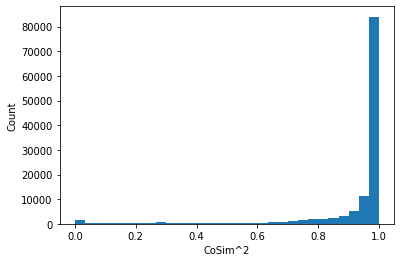

In [6]:
grad_FD = nn.finite_diff_grad(nn.weights_full, x.reshape(1,-1)) # M x num of samples in x_train

M = grad_FD.shape[0]
grad_angle = np.arctan(np.squeeze(grad_FD))
grad_angle_rep = np.tile(grad_angle,(M,1,1))
grad_angle_rep_transpose = np.transpose(grad_angle_rep, axes = [1,0,2]) # transpose the M x M matrix so we can take pairwise differences between auxiliary functions
coSimSqMat = np.cos(grad_angle_rep - grad_angle_rep_transpose)**2

plt.hist(coSimSqMat[np.triu(np.ones((M,M),dtype=bool),k=1)].flatten(),bins = 30);
plt.xlabel('CoSim^2')
plt.ylabel('Count')

## Inspect auxiliary functions before training

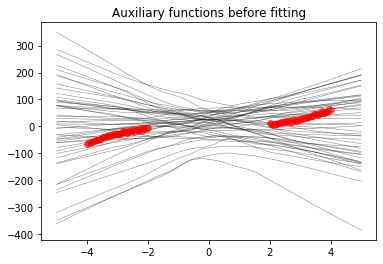

In [7]:
y_pred = nn.forward_with_auxiliary(nn.weights_full, x_test.reshape(1,-1))
plt.scatter(x,y,color = 'r',alpha = 0.5)
plt.plot(x_test, np.squeeze(y_pred).T,'k',linewidth = 0.5, alpha=0.5, zorder = 0)
plt.title('Auxiliary functions before fitting')
plt.show()

## Training LUNA

In [8]:
### define design choices in gradient descent
params = {'step_size':1e-2, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit LUNA
reg_param = 1.
lambda_in = 1.
nn.fit(x.reshape((1, -1)), y.reshape((1, -1)), params, lambda_in, reg_param = reg_param)


Iteration 0 loss 11638.870603289626; gradient mag: 5440.060306799734
Iteration 100 loss 869.4572291771024; gradient mag: 264.2786417533547
Iteration 200 loss 837.8274168113292; gradient mag: 321.6701458905579
Iteration 300 loss 822.7105403913105; gradient mag: 441.3285295549074
Iteration 400 loss 814.0278652257016; gradient mag: 587.6997778852842
Iteration 500 loss 808.3806967553826; gradient mag: 456.03836224877983
Iteration 600 loss 805.3572591169153; gradient mag: 386.19706005666507
Iteration 700 loss 803.913672187666; gradient mag: 342.63545516152516
Iteration 800 loss 805.5018197750037; gradient mag: 569.2022865608205
Iteration 900 loss 804.5482403815494; gradient mag: 650.4883162671482
Iteration 1000 loss 803.7479550399626; gradient mag: 584.315025111865
Iteration 1100 loss 803.1606105089782; gradient mag: 613.0693960997623
Iteration 1200 loss 800.5906571391191; gradient mag: 277.07318385851306
Iteration 1300 loss 799.998628425297; gradient mag: 242.7785755059392
Iteration 1400 l

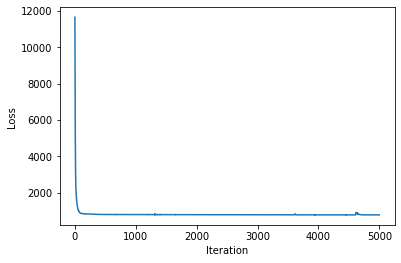

In [9]:
plt.plot(nn.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## Inspect distribution of coSim^2 after training

Text(0, 0.5, 'Count')

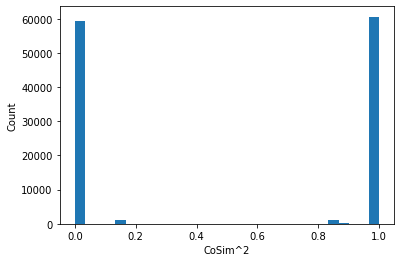

In [10]:
grad_FD = nn.finite_diff_grad(nn.weights_full, x.reshape(1,-1)) # M x num of samples in x_train

M = grad_FD.shape[0]
grad_angle = np.arctan(np.squeeze(grad_FD))
grad_angle_rep = np.tile(grad_angle,(M,1,1))
grad_angle_rep_transpose = np.transpose(grad_angle_rep, axes = [1,0,2]) # transpose the M x M matrix so we can take pairwise differences between auxiliary functions
coSimSqMat = np.cos(grad_angle_rep - grad_angle_rep_transpose)**2

plt.hist(coSimSqMat[np.triu(np.ones((M,M),dtype=bool),k=1)].flatten(),bins = 30);
plt.xlabel('CoSim^2')
plt.ylabel('Count')

## Inspect auxiliary functions after training

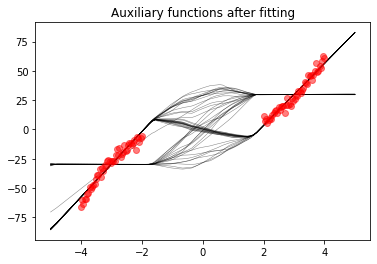

In [11]:
y_pred = nn.forward_with_auxiliary(nn.weights_full, x_test.reshape(1,-1))
plt.scatter(x,y,color = 'r',alpha = 0.5)
plt.plot(x_test, np.squeeze(y_pred).T,'k',linewidth = 0.5, alpha=0.5, zorder = 0)
plt.title('Auxiliary functions after fitting')
plt.show()

## Plot prior predictive

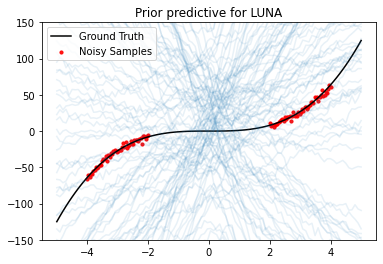

In [12]:
prior_var = 9
noise_var = 9
y_prior = nn.get_prior_samples(x_test, prior_var = prior_var, noise_var = noise_var)

plt.scatter(x,y, s = 10, color='red', alpha = 0.9, label='Noisy Samples')
plt.plot(x_test, x_test**3, color='black', label="Ground Truth")
plt.plot(x_test, y_prior, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Prior predictive for LUNA')
plt.legend()
plt.show()

## Plot posterior predictive

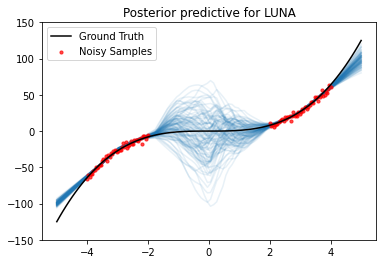

In [13]:
joint_mean, joint_variance, posterior, predictive = nn.perform_bayesian(x, y, x_test, prior_var = prior_var, noise_var = noise_var)

plt.scatter(x,y, color='red', s = 10, alpha = 0.7, label='Noisy Samples')
plt.plot(x_test, x_test**3, color='black', zorder=1,label="Ground Truth")
plt.plot(x_test, posterior.T, color='tab:blue', alpha=0.1, zorder=0)
plt.ylim([-150, 150])
plt.title('Posterior predictive for LUNA')
plt.legend()
plt.show()

In [14]:
# Calulating percentiles
pp_upper = np.percentile(predictive, 97.5, axis=0)
pp_lower = np.percentile(predictive, 2.5, axis=0)
pp_upper2 = np.percentile(predictive, 84, axis=0)
pp_lower2 = np.percentile(predictive, 16, axis=0)
pp_mean = np.mean(predictive, axis=0)

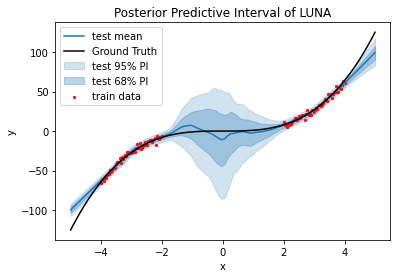

In [15]:
# Visualizing 95% posterior predictive interval 
plt.fill_between(x_test, pp_upper, pp_lower, color = 'tab:blue', alpha = 0.2, label = 'test 95% PI')
plt.fill_between(x_test, pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = 'test 68% PI')
plt.plot(x_test, pp_mean, color = 'tab:blue', alpha = 1, label = 'test mean')
plt.plot(x_test, x_test**3, color='black', label="Ground Truth")
plt.scatter(x, y, s=5, color = "red", label = "train data", alpha = 0.9)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.title("Posterior Predictive Interval of LUNA")
plt.show()

## Compare to NLM

In [16]:
# instantiate a NLM with same architecture and training parameters
nlm = NLM(architecture, random = random)
nlm.fit(x.reshape((1, -1)), y.reshape((1, -1)), params, reg_param = reg_param)

Iteration 0 loss 2217.4259747752285; gradient mag: 9264.859118244149
Iteration 100 loss 63.09374897630335; gradient mag: 46.24086738127938
Iteration 200 loss 48.25969190584514; gradient mag: 7.832886834775704
Iteration 300 loss 47.13894849853981; gradient mag: 7.165142303627143
Iteration 400 loss 46.45543595661962; gradient mag: 4.079550513956017
Iteration 500 loss 45.82810855320912; gradient mag: 5.525891181973751
Iteration 600 loss 45.22868946481057; gradient mag: 13.244323272901088
Iteration 700 loss 44.63938012567337; gradient mag: 26.551782018479887
Iteration 800 loss 44.045301693571695; gradient mag: 5.5954723931624235
Iteration 900 loss 43.47873203237278; gradient mag: 30.805340161633897
Iteration 1000 loss 42.88551763919946; gradient mag: 17.220622180691308
Iteration 1100 loss 42.333884640623424; gradient mag: 15.22101895744619
Iteration 1200 loss 41.76353841849539; gradient mag: 6.381808851156844
Iteration 1300 loss 41.20927636227357; gradient mag: 11.90108596606527
Iteration 

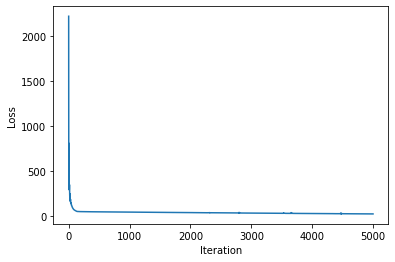

In [17]:
plt.plot(nlm.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

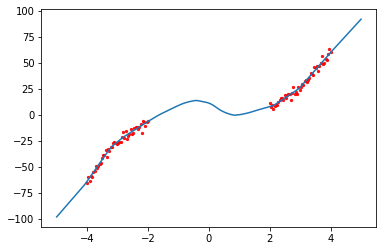

In [18]:
y_pred = nlm.forward(nlm.weights, x_test.reshape(1,-1))
plt.scatter(x,y,s=5,color = 'r',alpha = 0.9)
plt.plot(x_test, y_pred.flatten())
plt.show()

## Plot prior predictive

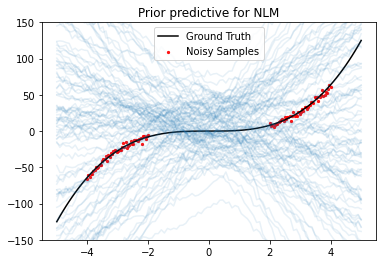

In [19]:
prior_var = 9
noise_var = 9
y_prior = nlm.get_prior_samples(x_test, prior_var = prior_var, noise_var = noise_var)

plt.scatter(x,y, s=5, color='red', alpha = 0.9, label='Noisy Samples')
plt.plot(x_test, x_test**3, color='black', label="Ground Truth")
plt.plot(x_test, y_prior, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Prior predictive for NLM')
plt.legend()
plt.show()

## Plot posterior predictive

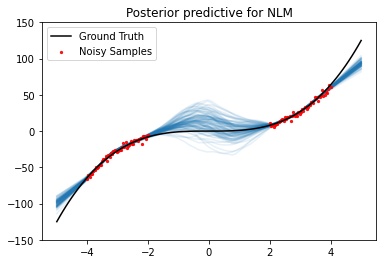

In [20]:
joint_mean, joint_variance, posterior, predictive = nlm.perform_bayesian(x, y, x_test, prior_var = prior_var, noise_var = noise_var)

plt.scatter(x,y, color='red', s = 5, alpha = 0.9, label='Noisy Samples')
plt.plot(x_test, x_test**3,zorder=1, color='black', label="Ground Truth")
plt.plot(x_test, posterior.T,zorder=0, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Posterior predictive for NLM')
plt.legend()
plt.show()

In [21]:
# Calulating percentiles
pp_upper = np.percentile(predictive, 97.5, axis=0)
pp_lower = np.percentile(predictive, 2.5, axis=0)

pp_upper2 = np.percentile(predictive, 84, axis=0)
pp_lower2 = np.percentile(predictive, 16, axis=0)

pp_mean = np.mean(predictive, axis=0)

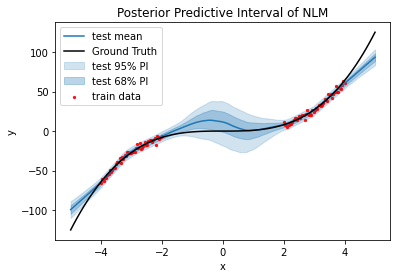

In [22]:
# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.fill_between(x_test, pp_upper, pp_lower, color = 'tab:blue', alpha = 0.2, label = 'test 95% PI')
plt.fill_between(x_test, pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = 'test 68% PI')
plt.plot(x_test, pp_mean, color = 'tab:blue', alpha = 1, label = 'test mean')
plt.plot(x_test, x_test**3, color='black', label="Ground Truth")
plt.scatter(x, y, s=5, color = "red", label = "train data", alpha = 0.9)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.title("Posterior Predictive Interval of NLM")
plt.show()